In [62]:
from keras.src.losses import mean_absolute_error
from matplotlib.pyplot import imread

# -*- coding: utf-8 -*-
"""
Created on Saturday Nov 15 15:34 2025

@author: 100yearsahead


Bleaching Presence Detection
Target variable: Percent_Bleaching

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os


path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

# Removed only locations and labels, no real data touched
# df.drop("Ocean_Name", axis=1, inplace=True)
# df.drop("Country_Name", axis=1, inplace=True)
# df.drop("Sample_ID", axis=1, inplace=True)
df.drop("Date_Year", axis=1, inplace=True)
# df.drop("Bleaching_Level", axis=1, inplace=True)
# df.drop("Realm_Name", axis=1, inplace=True)

# # df.drop("ClimSST", inplace=True, axis=1)
# df.drop("Exposure", inplace=True, axis=1)
# # df.drop("Temperature_Maximum", inplace=True, axis=1)

# label_encoder = LabelEncoder()
# df["Exposure"] = label_encoder.fit_transform(df["Exposure"])

# These features were taken into account that data is nonlinear
# df = df[["Distance_to_Shore", "Temperature_Mean", "Turbidity", "TSA", "Depth_m", "Percent_Bleaching"]]

# These features were taken into account that data is linear
#df = df[['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Bleaching']]

# #Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# # For the sake of bigger dataset this feature is dropped

cat_cols = ['Realm_Name','Ocean_Name','Country_Name','Exposure','Bleaching_Level']

df.drop("Percent_Cover", axis=1, inplace=True)
df.drop(cat_cols, axis=1, inplace=True)



df.dropna(inplace=True)

df.drop(columns=['Sample_ID'], axis=1, inplace=True)

df.info()
print(df)


<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Distance_to_Shore    32714 non-null  float64
 4   Turbidity            32714 non-null  float64
 5   Temperature_Maximum  32714 non-null  float64
 6   SSTA                 32714 non-null  float64
 7   TSA                  32714 non-null  float64
 8   Percent_Bleaching    32714 non-null  float64
 9   Temperature_Mean     32714 non-null  float64
dtypes: float64(10)
memory usage: 2.7 MB
       Cyclone_Frequency  Depth_m  ClimSST  Distance_to_Shore  Turbidity  \
0                  49.90    10.00   301.61            8519.23     0.0287   
1                  51.20    14.00   262.15            1431.62     0.0262   
2                  61.52   

In [34]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['Realm_Name','Ocean_Name','Country_Name','Exposure','Bleaching_Level']
num_cols = [col for col in df.columns if col not in cat_cols]


ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cat = ohe.fit_transform(df[cat_cols])


encoded_cat_cols = ohe.get_feature_names_out(cat_cols)


df = pd.concat([
    df[num_cols].reset_index(drop=True),
    pd.DataFrame(encoded_cat, columns=encoded_cat_cols)
], axis=1)

df.head()

,Cyclone_Frequency,Depth_m,ClimSST,Distance_to_Shore,Turbidity,Date_Year,Temperature_Maximum,SSTA,TSA,Percent_Bleaching,...,Country_Name_United States,Country_Name_Vanuatu,Country_Name_Venezuela,Country_Name_Vietnam,Country_Name_Yemen,Exposure_Exposed,Exposure_Sheltered,Exposure_Sometimes,Bleaching_Level_Colony,Bleaching_Level_Population
0,49.90,10.00,301.61,8519.23,0.0287,2005,304.69,-0.46,-0.80,50.2,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,51.20,14.00,262.15,1431.62,0.0262,1991,305.01,1.29,1.29,50.7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,61.52,7.00,298.79,182.33,0.0429,2006,304.14,0.04,-2.64,50.9,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,65.39,9.02,300.16,313.13,0.0424,2006,304.07,-0.07,-2.27,50.9,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,65.39,12.50,300.15,792.00,0.0424,2006,303.76,0.00,-2.19,50.9,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [52]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 29 15:40:04 2025

@author: zemsk


Bleaching Presence Detection

Goal: Classify whether bleaching occurred or not.
Target variable: Binary version of Percent_Bleaching

Not bleaching: [0% - 0.5%]
Bleaching: (0.5% - 100%]
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df["Percent_Bleaching"] = pd.to_numeric(df["Percent_Bleaching"], errors="coerce")


df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41361 entries, 0 to 41360
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample_ID            41361 non-null  int64  
 1   Cyclone_Frequency    41361 non-null  float64
 2   Depth_m              39562 non-null  float64
 3   ClimSST              41248 non-null  float64
 4   Ocean_Name           41361 non-null  object 
 5   Country_Name         41360 non-null  object 
 6   Distance_to_Shore    41359 non-null  float64
 7   Exposure             41361 non-null  object 
 8   Turbidity            41355 non-null  float64
 9   Date_Year            41361 non-null  int64  
 10  Bleaching_Level      41361 non-null  object 
 11  Temperature_Maximum  41229 non-null  float64
 12  SSTA                 41213 non-null  float64
 13  TSA                  41213 non-null  float64
 14  Percent_Bleaching    34515 non-null  float64
 15  Temperature_Mean     41229 non-null 

In [2]:

df.drop("Ocean_Name", axis=1, inplace=True)
df.drop("Country_Name", axis=1, inplace=True)
df.drop("Sample_ID", axis=1, inplace=True)
df.drop("Date_Year", axis=1, inplace=True)
df.drop("Bleaching_Level", axis=1, inplace=True)
df.drop("Realm_Name", axis=1, inplace=True)
df.drop("Exposure", axis=1, inplace=True)
#Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# For the sake of bigger dataset this feature is dropped
df.drop("Percent_Cover", axis=1, inplace=True)



In [3]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    32714 non-null  float64
 1   Depth_m              32714 non-null  float64
 2   ClimSST              32714 non-null  float64
 3   Distance_to_Shore    32714 non-null  float64
 4   Turbidity            32714 non-null  float64
 5   Temperature_Maximum  32714 non-null  float64
 6   SSTA                 32714 non-null  float64
 7   TSA                  32714 non-null  float64
 8   Percent_Bleaching    32714 non-null  float64
 9   Temperature_Mean     32714 non-null  float64
dtypes: float64(10)
memory usage: 2.7 MB


In [6]:
temperature_anomaly = df["Temperature_Maximum"] - df["Temperature_Mean"]

df = df.drop(["Temperature_Maximum"], axis=1)
# df["Temperature_Anomaly"] = temperature_anomaly
df = df.drop(["Cyclone_Frequency", "ClimSST"], axis=1)


In [58]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 29 15:40:04 2025

@author: zemsk


Bleaching Presence Detection
Target variable: Percent_Bleaching

"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import os


path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

# Removed only locations and labels, no real data touched
# df.drop("Ocean_Name", axis=1, inplace=True)
# df.drop("Country_Name", axis=1, inplace=True)
# df.drop("Sample_ID", axis=1, inplace=True)
df.drop("Date_Year", axis=1, inplace=True)
# df.drop("Bleaching_Level", axis=1, inplace=True)
# df.drop("Realm_Name", axis=1, inplace=True)
# # #Percent_Cover is not a best predictor and also contain 30% of its fields as null.
# # # For the sake of bigger dataset this feature is dropped
# df.drop("Percent_Cover", axis=1, inplace=True)
# # df.drop("ClimSST", inplace=True, axis=1)
# df.drop("Exposure", inplace=True, axis=1)
# # df.drop("Temperature_Maximum", inplace=True, axis=1)

# label_encoder = LabelEncoder()
# df["Exposure"] = label_encoder.fit_transform(df["Exposure"])

# These features were taken into account that data is nonlinear
# df = df[["Distance_to_Shore", "Temperature_Mean", "Turbidity", "TSA", "Depth_m", "Percent_Bleaching"]]

# These features were taken into account that data is linear
df = df[['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore', 'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Bleaching']]

df.dropna(inplace=True)
df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 32714 entries, 0 to 35044
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cyclone_Frequency  32714 non-null  float64
 1   Depth_m            32714 non-null  float64
 2   ClimSST            32714 non-null  float64
 3   Distance_to_Shore  32714 non-null  float64
 4   Turbidity          32714 non-null  float64
 5   TSA                32714 non-null  float64
 6   Temperature_Mean   32714 non-null  float64
 7   Percent_Bleaching  32714 non-null  float64
dtypes: float64(8)
memory usage: 2.2 MB


In [63]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["features"] = df.columns

vif_data["vif"] = [variance_inflation_factor(df.values, i)
                   for i in range(len(df.columns))]

vif_data

,features,vif
0,Cyclone_Frequency,51.860955
1,Depth_m,4.060596
2,ClimSST,411.180812
3,Distance_to_Shore,1.109021
4,Turbidity,3.253969
5,Temperature_Maximum,55534.515475
6,SSTA,1.607220
7,TSA,2.062368
8,Percent_Bleaching,1.270236
9,Temperature_Mean,54902.395242


Cyclone_Frequency highly dependent on depth(for some reason) and temperature mean, since cyclones occur at zones with a pressure difference, which depends on temperatures)

<Figure size 1000x500 with 0 Axes>

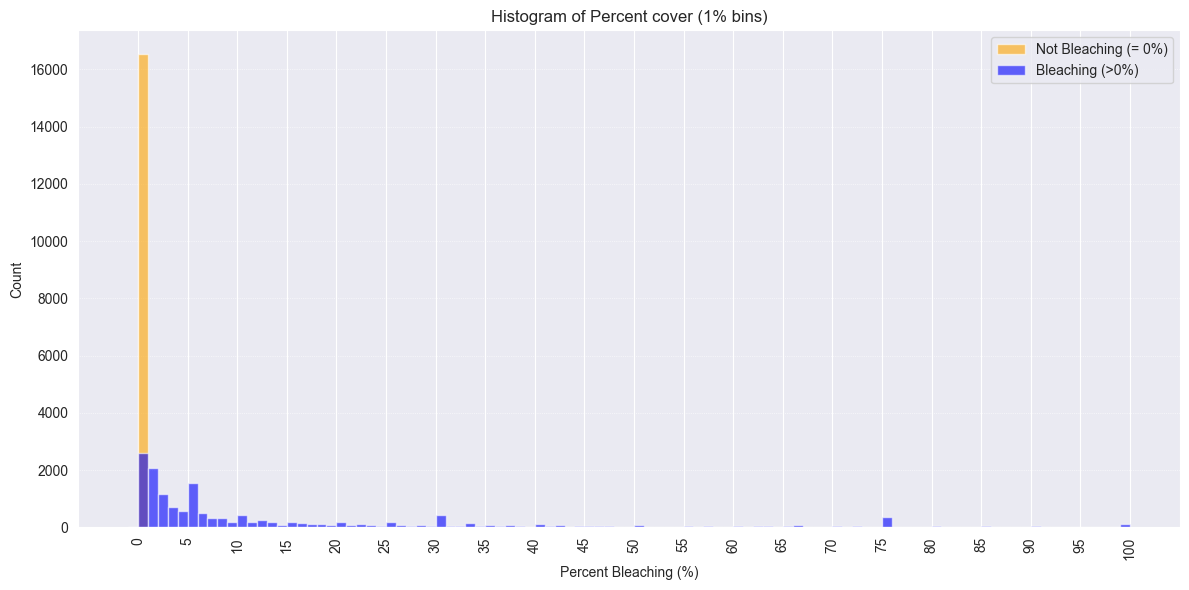

In [17]:

high_bleaching = df["Percent_Bleaching"] > 0  # 50% threshold
low_bleaching = df["Percent_Bleaching"] <= 0

bins = np.arange(-1, 101, 1)  # from 0 to 100 in steps of 0.5
labels = [f"{b}–{b+1}%" for b in bins[:-1:5]]


plt.figure(figsize=(10, 5))
plt.figure(figsize=(12, 6))
plt.hist(
    df.loc[low_bleaching, "Percent_Bleaching"],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Not Bleaching (= 0%)"
)
plt.hist(
    df.loc[high_bleaching, "Percent_Bleaching"],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Bleaching (>0%)"
)
plt.xticks(ticks=np.arange(0, 101, 5))
plt.xlabel("Percent Bleaching (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent cover (1% bins)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.legend()
plt.show()



In [77]:
"""
Plot data to see corelation between Percent Bleaching and Percent Cover
"""    
plt.figure(figsize=(8, 5))

plt.scatter(
    (df.loc[low_bleaching, "Percent_Bleaching"]),
    (df.loc[low_bleaching, "Percent_Cover"]),
    color="orange")

plt.scatter(
            (df.loc[high_bleaching, "Percent_Bleaching"]),
            (df.loc[high_bleaching, "Percent_Cover"]),
            color="Blue", alpha=0.3)      
   

plt.title("Bleaching % corelation to Cover %")
plt.xlabel("Bleaching")
plt.ylabel("Cover")

plt.xscale("symlog")
plt.yscale("symlog")

plt.show()


KeyError: 'Percent_Cover'

<Figure size 800x500 with 0 Axes>

In [9]:
print(len(low_bleaching[high_bleaching[:] == 1]) / len(low_bleaching[low_bleaching[:] == 1]))


print(df[high_bleaching[:] == 1].count())
print(df[low_bleaching[:] == 1].count())
"""
See total distribution of classes

Bleaching:	6,015	26.66%
Not bleaching:	16,546	73.34%

Most of corals werent bleached
0.42053897494018383
low bleaching/ High bleaching
after dropping all na rows


most of data is distributed around 0
"""


0.9782306343351272
Cyclone_Frequency      16177
Depth_m                16177
ClimSST                16177
Distance_to_Shore      16177
Exposure               16177
Turbidity              16177
Bleaching_Level        16177
Temperature_Maximum    16177
SSTA                   16177
TSA                    16177
Percent_Bleaching      16177
Temperature_Mean       16177
Realm_Name             16177
dtype: int64
Cyclone_Frequency      16537
Depth_m                16537
ClimSST                16537
Distance_to_Shore      16537
Exposure               16537
Turbidity              16537
Bleaching_Level        16537
Temperature_Maximum    16537
SSTA                   16537
TSA                    16537
Percent_Bleaching      16537
Temperature_Mean       16537
Realm_Name             16537
dtype: int64


'\nSee total distribution of classes\n\nBleaching:\t6,015\t26.66%\nNot bleaching:\t16,546\t73.34%\n\nMost of corals werent bleached\n0.42053897494018383\nlow bleaching/ High bleaching\nafter dropping all na rows\n\n\nmost of data is distributed around 0\n'

In [54]:

corr_matrix = df.corr(method="spearman")

features = corr_matrix.index
features

Index(['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore',
       'Turbidity', 'Date_Year', 'Temperature_Maximum', 'SSTA', 'TSA',
       'Percent_Bleaching', 'Temperature_Mean'],
      dtype='object')

<Axes: >

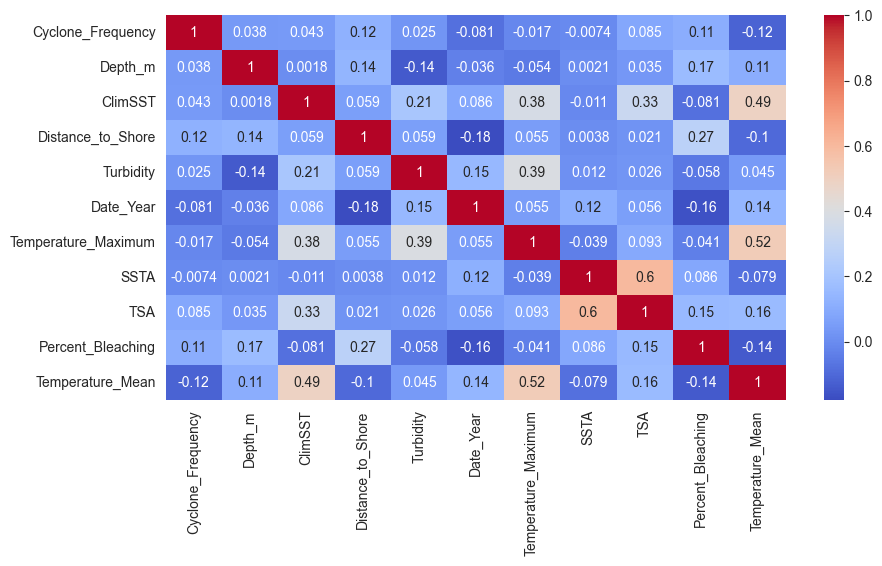

In [55]:
import seaborn as sns


plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")


TSA feature highly dependent on SSTA and have high correlation rate.
 It means we can drop it for better prediction

Definition:
weeks SST TSA
Thermal Stress Anomaly: Weekly sea surface temperature minus the maximum of weekly
climatological sea surface temperature

Exposure not a good predictor
Also Temperature mean and max are highly dependent, but mean is a better predictor so max gonna be dropped

Bleaching doesnt rely on Bleaching level


In [56]:
from sklearn.feature_selection import mutual_info_regression

x = df.drop(columns=['Percent_Bleaching'])
y = df['Percent_Bleaching']

mi = mutual_info_regression(x, y)
mi_scores = pd.Series(mi, index=x.columns).sort_values(ascending=False)

mi_scores

Distance_to_Shore      0.806850
Cyclone_Frequency      0.737031
Temperature_Mean       0.619490
Turbidity              0.612627
Temperature_Maximum    0.503442
TSA                    0.448775
ClimSST                0.401038
SSTA                   0.366326
Date_Year              0.349308
Depth_m                0.186159
dtype: float64

In [14]:
col = ['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore',
       'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Cover']


Out of this histogram it can be inferred that all sort of temperature parameters are the best predictors of coral bleaching

Preprocessing steps what are we predicting
are we using balancing techniques like under sampling?
Add some coral based research as well for intepretability and introductoin
Lasso + linear regression
DECIDE ON BAGGING TECHNIQUES
TRAIN TEST AND EVALUATION CHOOSE THIS
find the best model we can possibly even comment on other features that we did not consider

SVM,  ADDED MAYBE (LINEAR INTERPOLATION), SOME NEURAL NETWORK

In [68]:
from sklearn.model_selection import train_test_split

"""We have to mention that TTS was chosen over kfold, since DS is large enough to mitigate TTS overfitting issues and it saves us a lot of computational power since we need to train just 1 model instead of n"""
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
from sklearn.svm import SVR

model = SVR(kernel="linear", degree=2, shrinking=True, tol=0.001)
model.fit(X_train, y_train)

In [74]:
from sklearn.metrics import r2_score, mean_absolute_error

baseline_y = model.predict(X_test)
score = r2_score(y_test, baseline_y)
print(f"Accuracy score for baseline prediction: {score}")
mean_absolute_error(y_test, baseline_y)


Accuracy score for baseline prediction: -0.15342278378622187


7.865290174372002

Degree 2 results:

Accuracy score for baseline prediction: -0.1849112793714336
19.54785694244967

Degree 3 results:
Accuracy score for baseline prediction: -0.19077496012283235
19.596164751852235

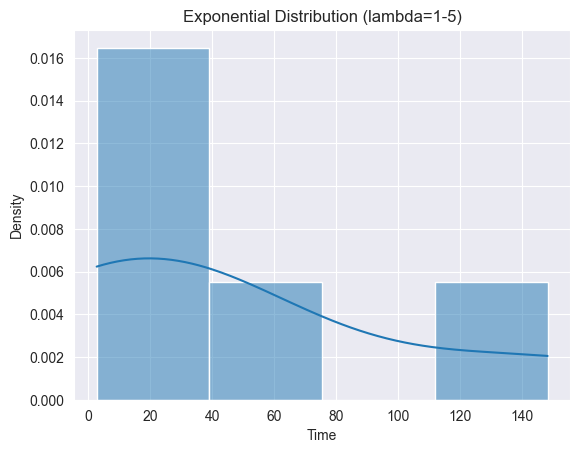

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the rate parameter lambda
t = [1, 2, 3 , 4, 5]
# Generate exponential data
data = np.exp(t)

# Plot the KDE and histogram
sns.histplot(data, kde=True, stat="density")
plt.title("Exponential Distribution (lambda=1-5)")
plt.xlabel("Time")
plt.ylabel("Density")
plt.show()